In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, impute, inspection, model_selection, pipeline, cluster, metrics, decomposition, feature_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Credit: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 25
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text siz
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl

## Import Data

### Large Dataset

In [4]:
# Import dataset
ldf = pd.read_csv("../data/dota2_matches_large_encoded.csv")
ldf.drop(columns='lobby_type', inplace=True)
print(ldf.shape)
ldf.head()

(209890, 325)


,radiant_win,dire_rating,dire_wins,dire_losses,radiant_rating,radiant_wins,radiant_losses,cluster_0,cluster_1,cluster_2,...,radiant_Monkey King,radiant_Dark Willow,radiant_Pangolier,radiant_Grimstroke,radiant_Hoodwink,radiant_Void Spirit,radiant_Snapfire,radiant_Mars,radiant_Dawnbreaker,radiant_Marci
0,True,917.940,9,19,1132.550,104,128,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,True,871.514,14,30,972.515,2,3,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,False,1132.550,104,128,917.940,9,19,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
3,True,972.515,2,3,871.514,14,30,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,True,1092.110,15,8,1093.280,142,121,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [5]:
# Create train and test sets
Xl = ldf.drop("radiant_win", axis=1)
yl = ldf["radiant_win"]

#### Explore the data

In [6]:
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209890 entries, 0 to 209889
Columns: 325 entries, radiant_win to radiant_Marci
dtypes: bool(1), float64(76), int64(248)
memory usage: 519.0 MB


In [7]:
yl.value_counts(normalize=1)

True     0.5
False    0.5
Name: radiant_win, dtype: float64

In [8]:
#Store the importances of features
imp_large = pd.DataFrame()

In [9]:
# For feature selection classifiers later on
og_large_score = dict()

## Classification Models

### K-fold coss-validation

In [10]:
def k_fold_validate(folds, model, features, target, model_type, output=True):
    kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=3)
    
    rec, prec, f1 = [], [], []
    imp_df = pd.DataFrame()
    for train_index, test_index in kf.split(features):
        # Retrieve the train and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Standardize the data to optimize performance
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model
        rec += [metrics.recall_score(y_pred, y_test)]
        prec += [metrics.precision_score(y_pred, y_test)]
        f1 += [metrics.f1_score(y_pred, y_test)]
        
        # Store the feature importances for the fold
        if model_type == 'lrm':
            imps = abs(model.coef_[0])
        elif model_type == 'dtm' or model_type == 'rfm':
            imps = model.feature_importances_
        elif model_type == 'nbm':
            imps = inspection.permutation_importance(model, X_test, y_test).importances_mean
          
        imps = {k:v for k,v in enumerate(imps)}
        imp_df = imp_df.append(imps, ignore_index=True)
        
    if output:
        print("recall    = {:.4f} ±{:.4f} {}".format(np.mean(rec), np.std(rec), rec))
        print("precision = {:.4f} ±{:.4f} {}".format(np.mean(prec), np.std(prec), prec))
        print("f1        = {:.4f} ±{:.4f} {}".format(np.mean(f1), np.std(f1), f1))
    
    scores = {'recall': [np.mean(rec), np.std(rec)],
              'precision': [np.mean(prec), np.std(prec)],
              'f1': [np.mean(f1), np.std(f1)],
              'feature_ranks': {k:v for k, v in enumerate(imp_df.mean(axis=0))}            
             }        
        
    return scores

### Logistic Regression

In [11]:
# Large Dataset
lrm = LogisticRegression(max_iter=1000)
scores = k_fold_validate(5, lrm, Xl, yl, 'lrm')
og_large_score['lrm'] = scores['f1'][0]
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6362 ±0.0035 [0.6299548901046166, 0.6375746001432323, 0.6367704465390841, 0.6406965648854962, 0.6362080441190453]
precision = 0.6353 ±0.0051 [0.6254228405355186, 0.637270341207349, 0.6394187102633969, 0.6355418835778514, 0.6386979763268423]
f1        = 0.6358 ±0.0040 [0.6276806847251775, 0.6374224343675418, 0.6380918306499702, 0.6381088144452364, 0.63745057876435]


### Decision Tree

In [12]:
# Large Dataset
dtm = DecisionTreeClassifier()
scores = k_fold_validate(5, dtm, Xl, yl, 'dtm')
og_large_score['dtm'] = scores['f1'][0]
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6051 ±0.0038 [0.6015009024413414, 0.6092892262160485, 0.6011305339160175, 0.6099666189794946, 0.6037026461069864]
precision = 0.6056 ±0.0019 [0.603363666682548, 0.609114769744691, 0.604952435584875, 0.6053478466635116, 0.6054314623902253]
f1        = 0.6054 ±0.0026 [0.6024308446114692, 0.6092019854906453, 0.603035429224941, 0.6076484560570071, 0.6045658183204651]


### Random Forest

In [13]:
# Large Dataset
rfm = RandomForestClassifier()
scores = k_fold_validate(5, rfm, Xl, yl, 'rfm')
og_large_score['rfm'] = scores['f1'][0]
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6732 ±0.0029 [0.6696752673403316, 0.6730489578284052, 0.6781784240518766, 0.6737387563551036, 0.6711366850343785]
precision = 0.6564 ±0.0046 [0.6504359426366192, 0.6626103555237414, 0.6599263827142788, 0.6522479886417416, 0.6568823978617793]
f1        = 0.6647 ±0.0033 [0.6599154078549849, 0.6677888661777083, 0.6689279224712296, 0.6628192180060597, 0.6639330422827371]


### Naive Bayes

 WARNING: Takes a 15-20 min to run

In [14]:
# Large Dataset
nbm = GaussianNB()
scores = k_fold_validate(5, nbm, Xl, yl, 'nbm')
og_large_score['nbm'] = scores['f1'][0]
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.5473 ±0.0267 [0.5558936062324252, 0.5467196819085487, 0.49826001391988867, 0.5562627869970448, 0.5791245791245792]
precision = 0.4394 ±0.3705 [0.5745390442612797, 0.026246719160104987, 0.9924470576987428, 0.5790345480359678, 0.024627720504009163]
f1        = 0.3787 ±0.2718 [0.5650625556440653, 0.050088793770775464, 0.6634391077876841, 0.5674202898550725, 0.047246257382227715]


### Clean Up

In [15]:
#add column and row labels
imp_large['model'] = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']
imp_large.set_index('model', inplace=True)
imp_large.columns = Xl.columns
imp_large.shape

(4, 324)

## Feature Analysis

Brownlee, Jason. “How to Choose a Feature Selection Method for Machine Learning.” How to Choose a Feature Selection Method For Machine Learning, Machine Learning Mastery, 20 Aug. 2020, https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/. 

In [16]:
#Create pipeline for grid search
pipe = pipeline.Pipeline([
                     ('scaler',preprocessing.StandardScaler()),
                     ('model',Ridge())
])

### Large Dataset

#### Plot top features from model coeffiecents

In [17]:
#Scall all importances between 0 and 1
imp_large_inv = imp_large.transpose()
mm_scaler = preprocessing.MinMaxScaler()
imp_large_inv = pd.DataFrame(mm_scaler.fit_transform(imp_large_inv), columns=imp_large_inv.columns, index=imp_large_inv.index)
large_imp = imp_large_inv.transpose()
large_imp.shape

(4, 324)

In [18]:
# Find the top 5 important features for each model
models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']
top = list()
for model in models:
    ranks = large_imp.loc[model,:]
    sorted_ranks = {imp_large.columns[k]:v for k,v in sorted(enumerate(ranks), key=lambda item: item[1], reverse=True)}
    top.extend([list(sorted_ranks.keys())[i] for i in range(7)])
    
#New df of only the top columns
top_df = large_imp.copy()
cols = [i for i in imp_large.columns if i not in set(top)]
top_df.drop(columns=cols, inplace=True)

top_df.sort_values(['Decision Trees', 'Random Forest', 'Logistic Regression', 'Naive Bayes'],axis=1, inplace=True)

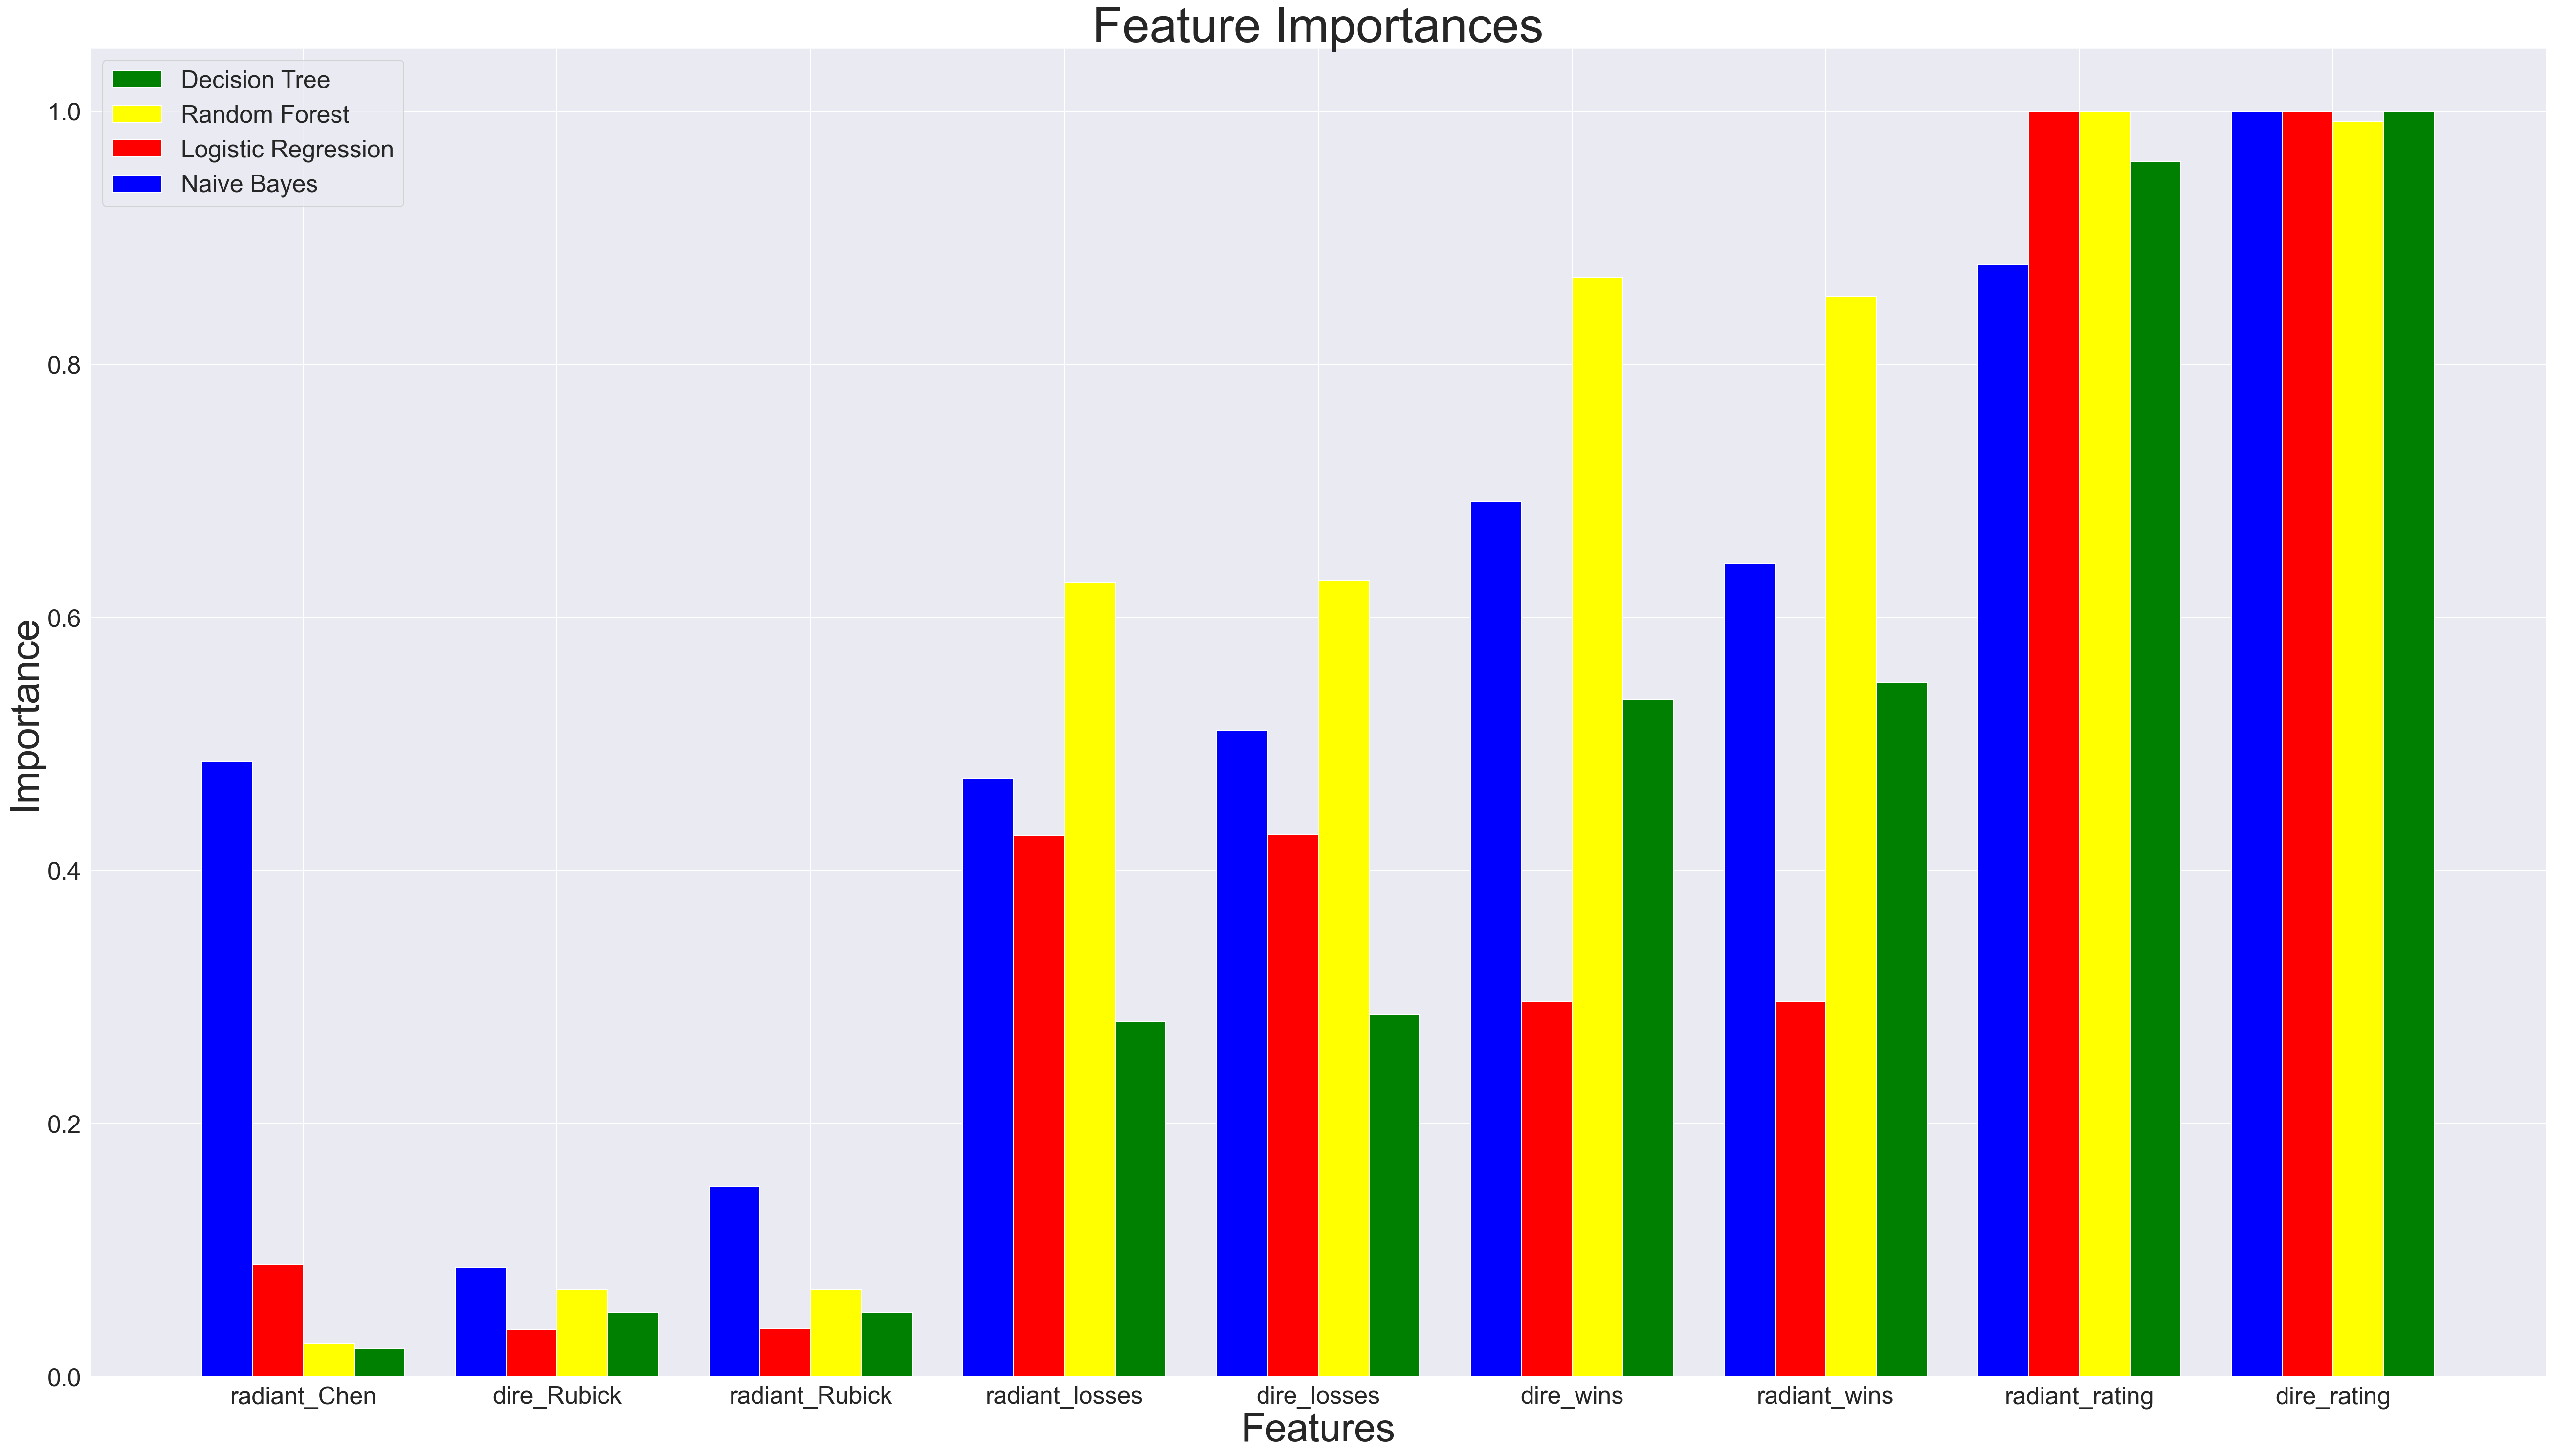

In [19]:
# Create Figure and subplots
index = np.arange(top_df.shape[1]*2, step=2)
fig, ax = plt.subplots(figsize=(45, 25))

# Plots bars
ax.bar(index + 1.2, top_df.iloc[1, :], .4, color='green', label='Decision Tree')
ax.bar(index + .8, top_df.iloc[2, :], .4, color='yellow',  label='Random Forest')
ax.bar(index + .4, top_df.iloc[0, :], .4, color='red', label='Logistic Regression')
ax.bar(index, top_df.iloc[3, :], .4, color='blue', label='Naive Bayes')

# Annotate graph
ax.set(xticks=index+0.6, xticklabels=top_df.columns)
ax.legend()
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('feature_importance_large.png')
plt.show()

#### Pearson correlation for the some the top important features 

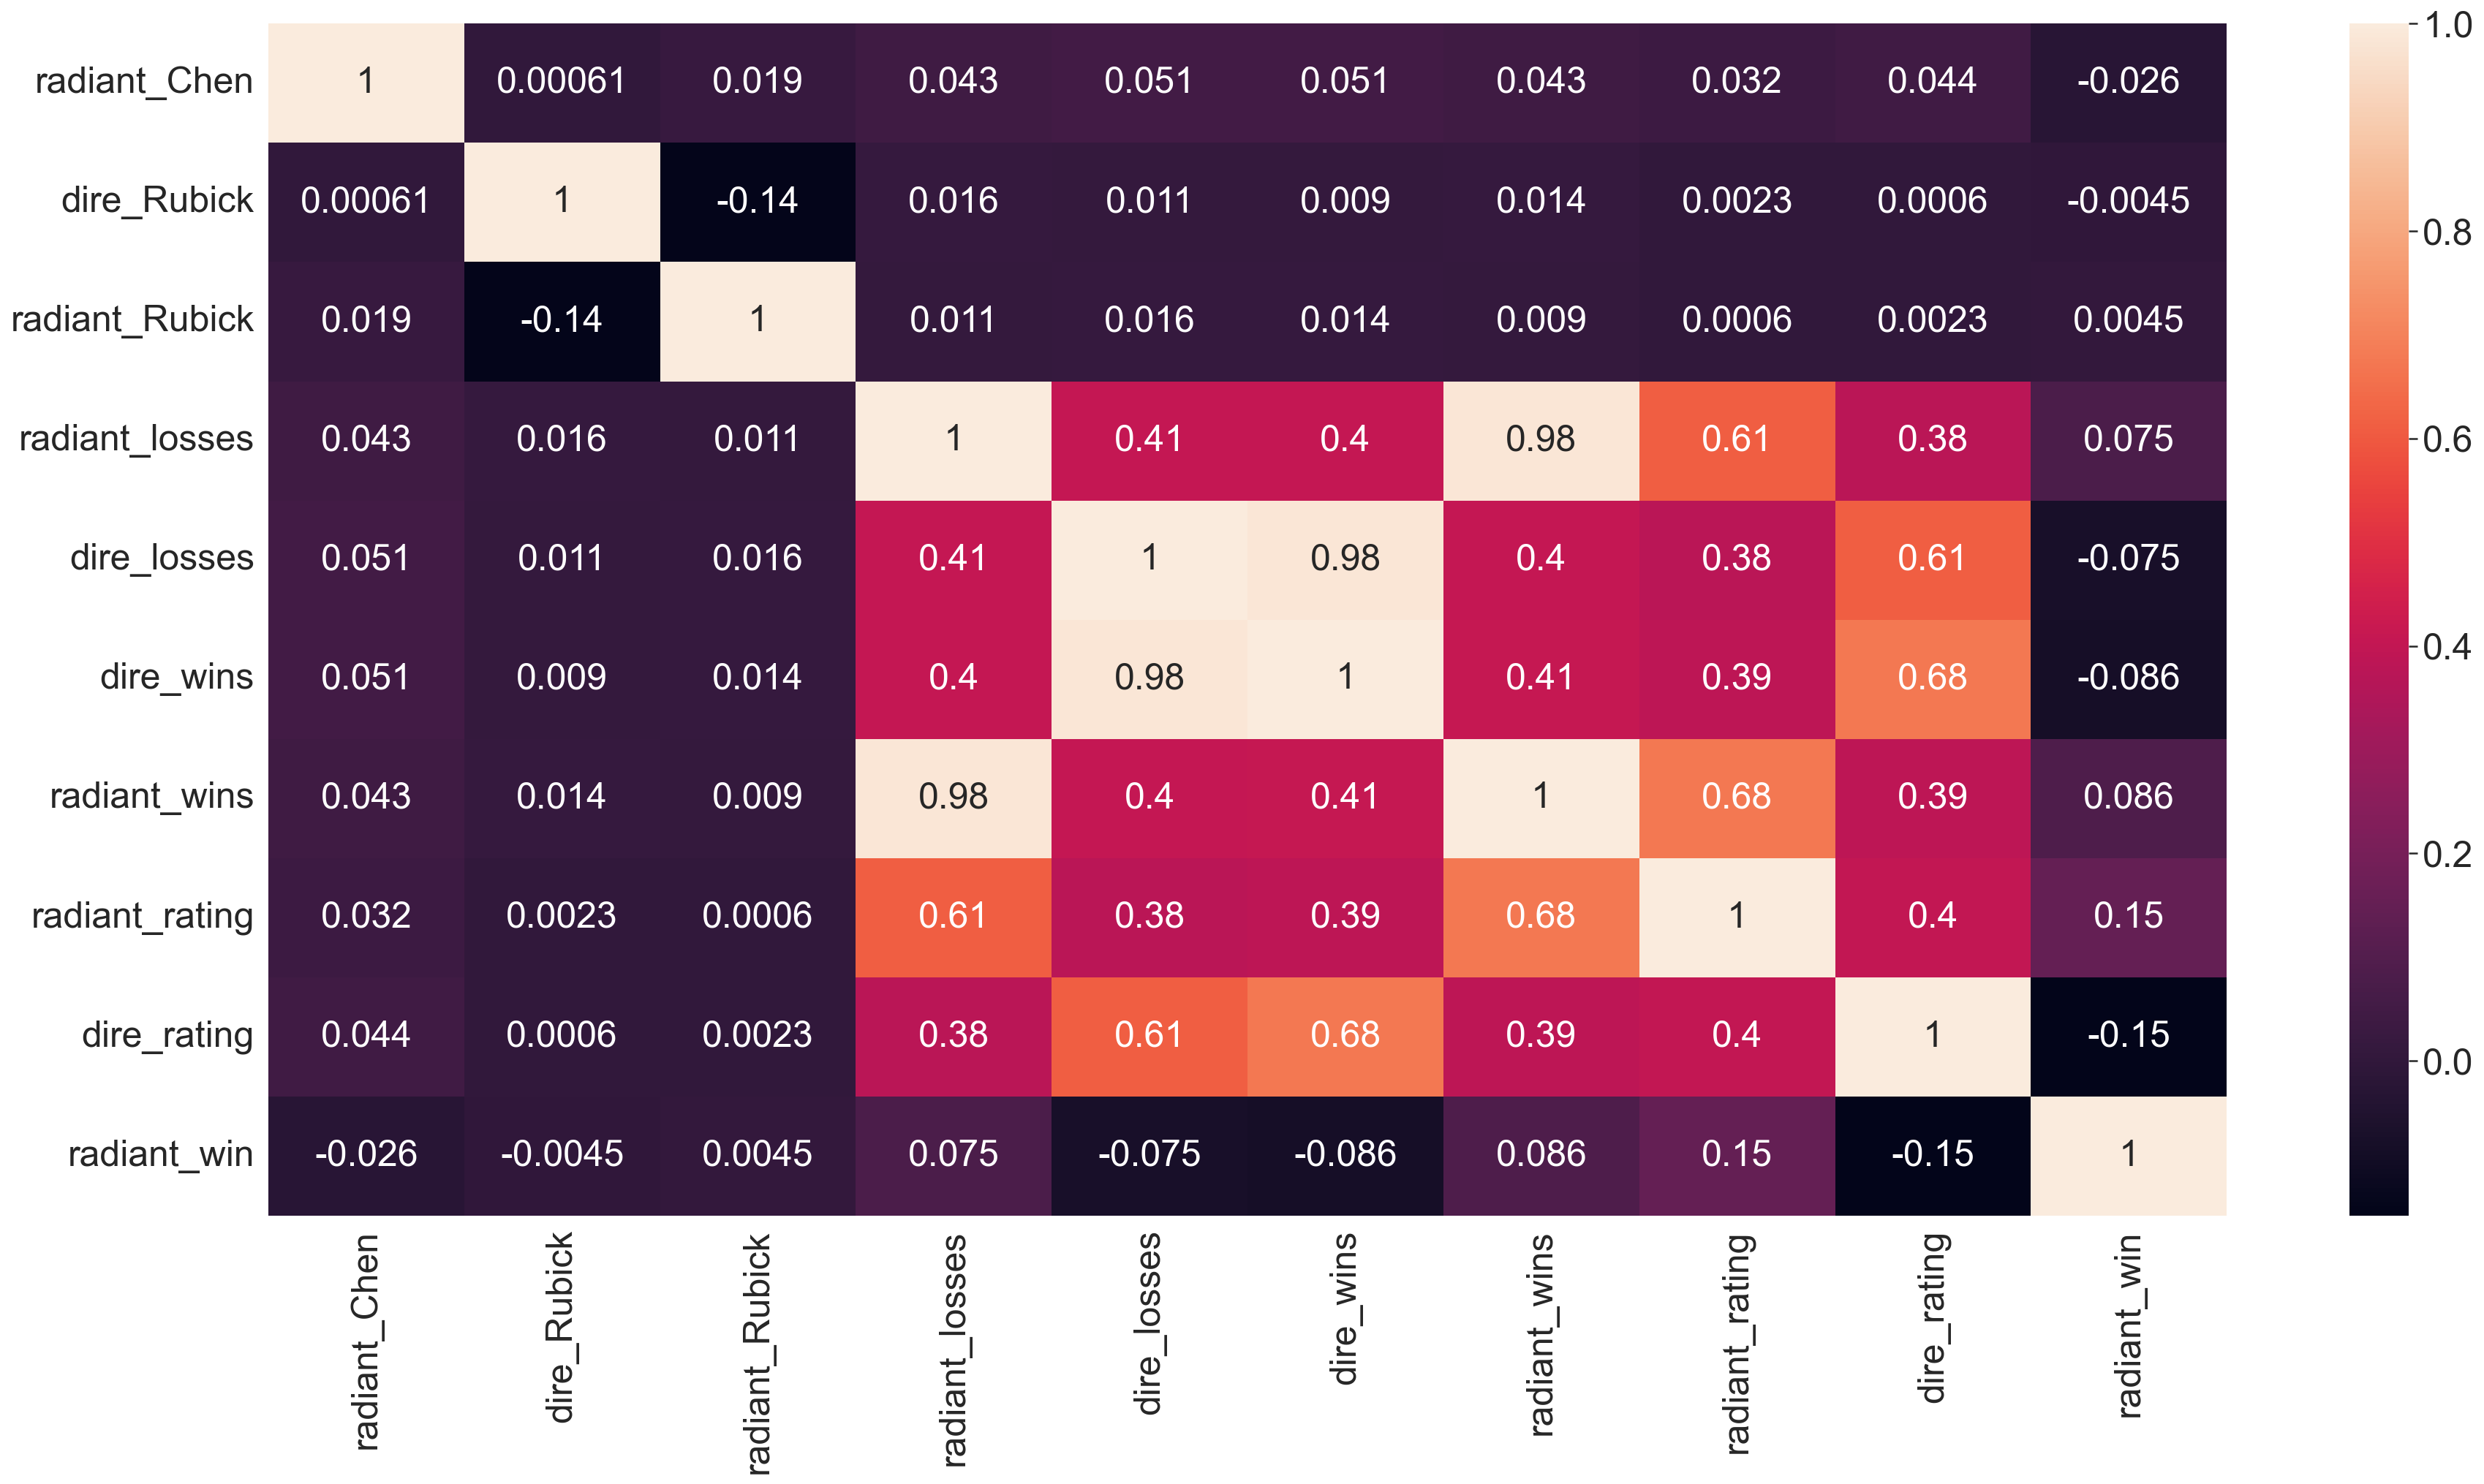

In [20]:
#Calculate the pearson correlation matrix and plot it
top_cols = list(top_df.columns)
top_cols.append('radiant_win')
corr = ldf[top_cols].corr(method='pearson')

#plot the matrix
plt.figure(figsize=(30,15))
sns.heatmap(corr, annot=True)
plt.savefig('feature_pcorrelation_large.png')

### Recap on top features

Print top 5 ranked features for every model and dataset

In [21]:
for model in models:
    # Get model ranks
    large = {k:v for k,v in sorted(zip(large_imp.columns, large_imp.loc[model, :]), key=lambda item: item[1], reverse=True)}
    
    large_keys = list(large.keys())
    large_vals = list(large.values())
    
    # print the top ranked features
    print("{: <20}{} Feature Importance".format("", model))
    print("{: <15}Large Dataset{: <10}".format("","",""))
    
    for i in range(5):
        print("{:2.0f}. {: <20} - {:2.4f}".format(i+1, large_keys[i], large_vals[i]))
        
    print()

                    Logistic Regression Feature Importance
               Large Dataset          
 1. radiant_rating       - 1.0000
 2. dire_rating          - 0.9999
 3. dire_losses          - 0.4284
 4. radiant_losses       - 0.4281
 5. dire_wins            - 0.2964

                    Decision Trees Feature Importance
               Large Dataset          
 1. dire_rating          - 1.0000
 2. radiant_rating       - 0.9606
 3. radiant_wins         - 0.5485
 4. dire_wins            - 0.5356
 5. dire_losses          - 0.2865

                    Random Forest Feature Importance
               Large Dataset          
 1. radiant_rating       - 1.0000
 2. dire_rating          - 0.9917
 3. dire_wins            - 0.8683
 4. radiant_wins         - 0.8538
 5. dire_losses          - 0.6289

                    Naive Bayes Feature Importance
               Large Dataset          
 1. dire_rating          - 1.0000
 2. radiant_rating       - 0.8792
 3. dire_wins            - 0.6917
 4. radiant_

## Feature Selected Classifiers

In [22]:
# Function that runs a set of classifiers and returns their f1 scores 
def feature_selected_classifiers(features, labels):
    models = ['lrm', 'dtm', 'rfm', 'nbm']
    
    f1_scores = dict()
    
    #Create each of the models
    for model in models:
        if model == 'lrm':
            classifier = LogisticRegression(max_iter=1000)
        elif model == 'dtm': 
            classifier = DecisionTreeClassifier()
        elif model == 'rfm':
            classifier = RandomForestClassifier()
        else:
            classifier = GaussianNB()
            
        # Run 5-Fold cross validation with all 4 models for the given features and labels
        scores = k_fold_validate(5, classifier, features, labels, model, False)
        f1_scores[model] = (scores['f1'][0])

    return f1_scores

In [23]:
# Create dataframe for scores on different feature selection methods (add original ones too)

large_scores = pd.DataFrame()

large_scores = large_scores.append(og_large_score, ignore_index=True)

WARNING: Takes 10-15 min to run

In [24]:
# Run all classifiers on 6 different feature selection methods

large_top = large_imp.shape[1] // 10

# Print number of top features
print("{} Top features from dataset 2.".format(large_top))

models = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']
for model in models:
    #Retrieve the ordered list of features by importance
    large = {k:v for k,v in sorted(zip(large_imp.columns, large_imp.loc[model, :]), key=lambda item: item[1], reverse=True)}
    
    # Run classifiers on top features of large dataset
    features = [list(large.keys())[i] for i in range(large_top)]
    large_scores = large_scores.append(feature_selected_classifiers(Xl[features], yl), ignore_index=True)

32 Top features from dataset 2.


In [25]:
temp_large = large_scores.copy()

#### Add Pearson Correlation

In [26]:
## LARGE DATA SET

# define feature selection
fs = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=large_top)
X_selected = pd.DataFrame(fs.fit_transform(Xl, yl))
large_scores = large_scores.append(feature_selected_classifiers(X_selected, yl), ignore_index=True)
print("Pearson Correlation dataset 2 features: {}".format(X_selected.shape[1]))

Pearson Correlation dataset 2 features: 32


In [27]:
# Add labels and index
large_scores.columns = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']

models.insert(0, 'Original Scores')
models.append('Pearson Correlation')
large_scores.index = models

In [28]:
large_scores

,Logistic Regression,Decision Trees,Random Forest,Naive Bayes
Original Scores,0.635751,0.605377,0.664677,0.378651
Logistic Regression,0.639889,0.604801,0.653542,0.585079
Decision Trees,0.644729,0.602272,0.652398,0.586766
Random Forest,0.646210,0.603547,0.654322,0.595369
Naive Bayes,0.641817,0.607187,0.652628,0.599241
Pearson Correlation,0.640267,0.605713,0.652699,0.584402


#### Graph feature selection matrix

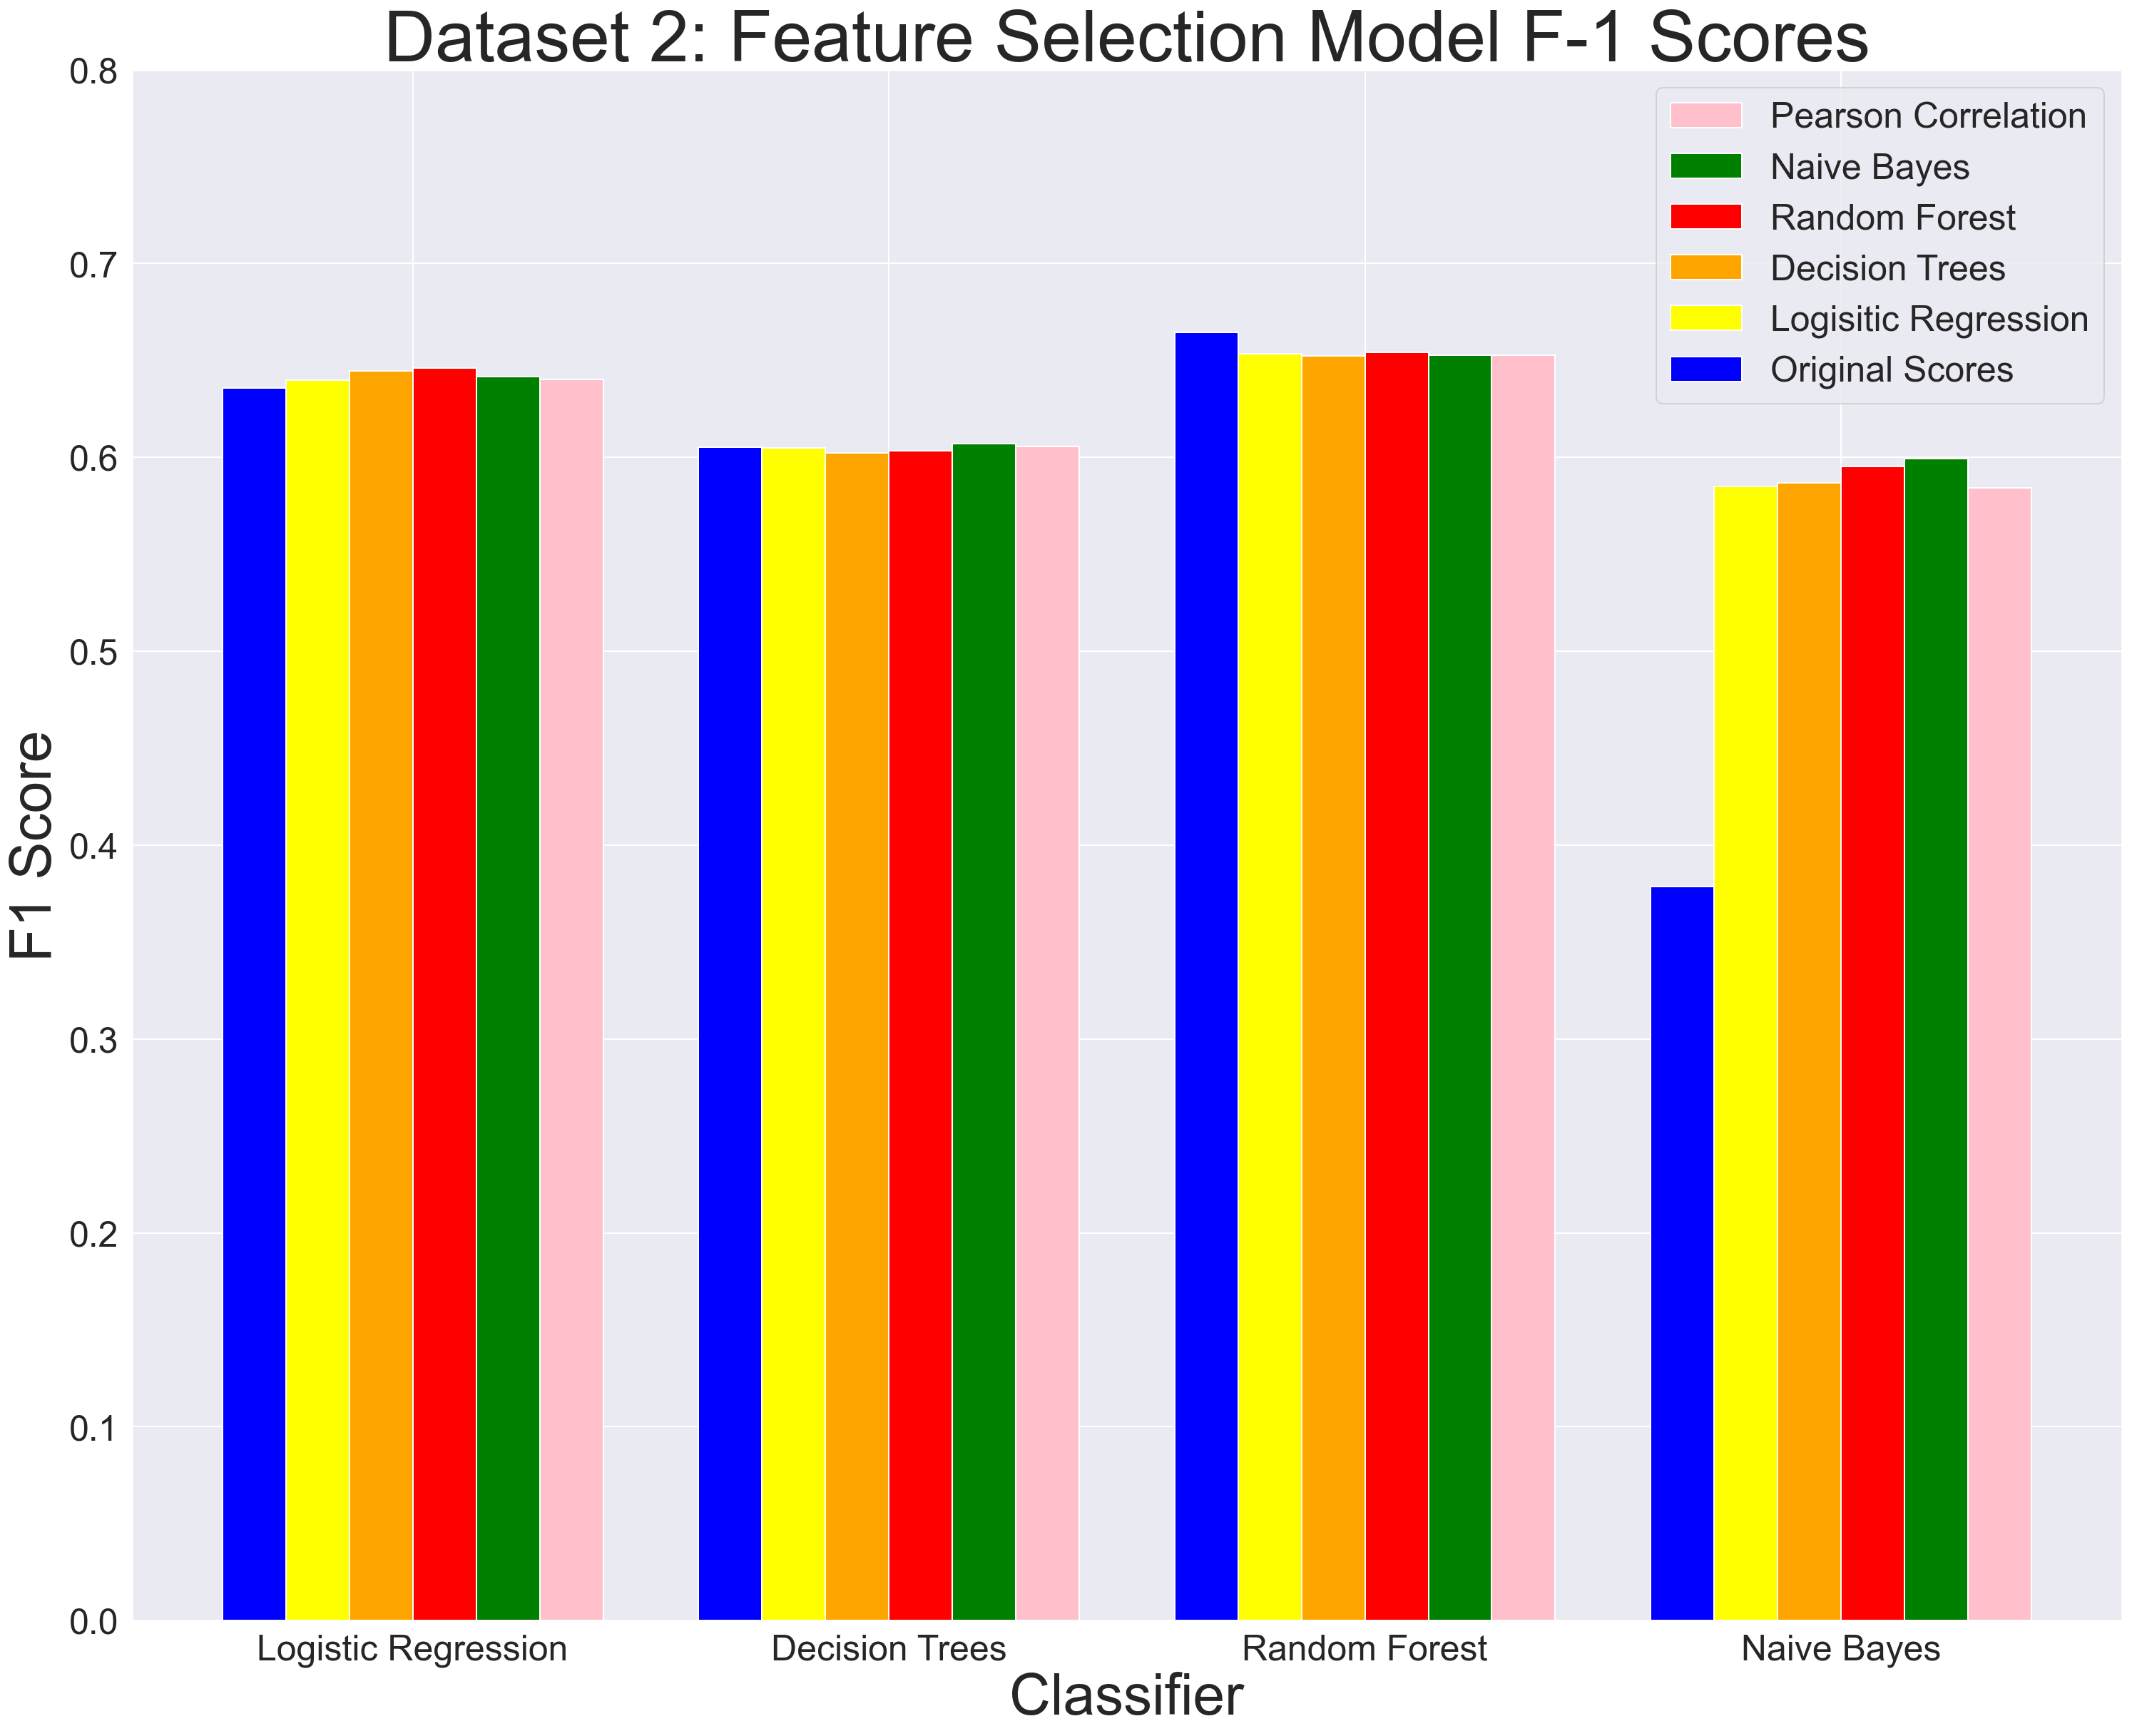

In [29]:
# Create Figure and Subplot
index = np.arange(large_scores.shape[1]*3, step=3)
fig, ax = plt.subplots(figsize=(25, 20))

# Plot Bars and its labels
ax.bar(index + 2.0, large_scores.iloc[5, :], .4, color='pink', label='Pearson Correlation')
ax.bar(index + 1.6, large_scores.iloc[4, :], .4, color='green',  label='Naive Bayes')
ax.bar(index + 1.2, large_scores.iloc[3, :], .4, color='red', label='Random Forest')
ax.bar(index + .8, large_scores.iloc[2, :], .4, color='orange', label='Decision Trees')
ax.bar(index + .4, large_scores.iloc[1, :], .4, color='yellow', label='Logisitic Regression')
ax.bar(index, large_scores.iloc[0, :], .4, color='blue', label='Original Scores')

# Annotate graph
ax.set(xticks=index+1, xticklabels=large_scores.columns)
ax.set_ylim(0, .8)
ax.legend()
plt.title('Dataset 2: Feature Selection Model F-1 Scores')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.savefig('feature_selection_large.png')
plt.show()

## PCA

#### Large Dataset

In [30]:
# Create train test splits
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xl, yl, shuffle=True, test_size=0.3, random_state=7)
X_train.shape

(146923, 324)

 Perform PCA on features with 2, 3, 7 PCA components

In [31]:
def perform_pca(train: pd.DataFrame, test: pd.DataFrame, components: int):
    scl = preprocessing.StandardScaler()
    scl = scl.fit(train)
    scl_train = pd.DataFrame(scl.transform(train), index=train.index, columns=train.columns)
    scl_test = pd.DataFrame(scl.transform(test), index=test.index, columns=test.columns)

    pca = decomposition.PCA(n_components=components)
    pca = pca.fit(train)

    pca_train = pd.DataFrame(pca.transform(scl_train))
    pca_train.index = scl_train.index

    pca_test = pd.DataFrame(pca.transform(scl_test))
    pca_test.index = scl_test.index

    return pca_train, pca_test

X_train_pca_2, X_test_pca_2 = perform_pca(X_train, X_test, 2)
X_train_pca_3, X_test_pca_3 = perform_pca(X_train, X_test, 3)
X_train_pca_7, X_test_pca_7 = perform_pca(X_train, X_test, 7)

 Plot PCA 2

Text(0, 0.5, 'PCA Component 2')

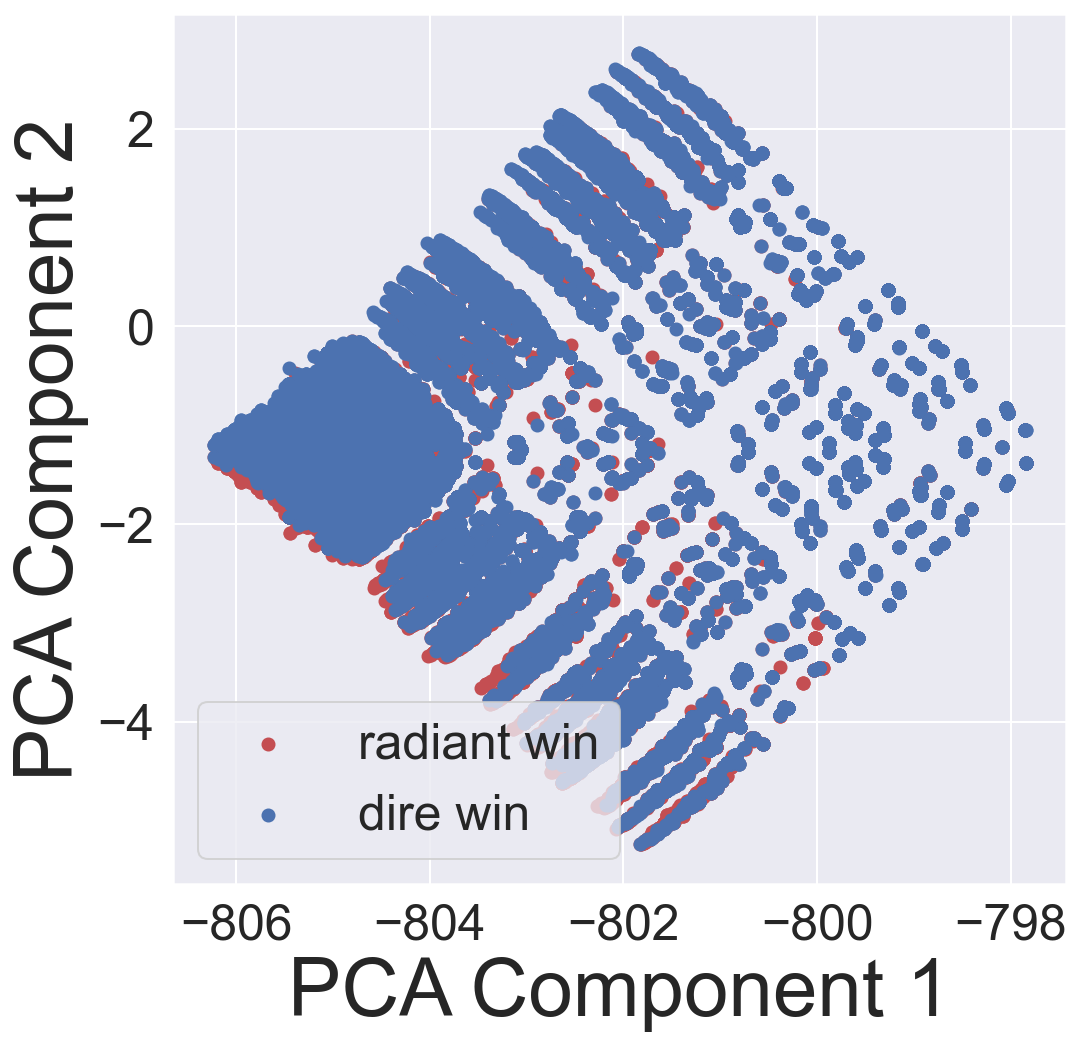

In [32]:
 #plot the PCA with color labels
fig, ax = plt.subplots(figsize=(8, 8))
color = ['r', 'b']
label = ['radiant win', 'dire win']

for t in {0, 1}:
    win_mask = y_train == t
    ax.scatter(X_train_pca_2.values[win_mask, 0], X_train_pca_2.values[win_mask, 1],
             label=label[t], color=color[t])

ax.legend()
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

Plot PCA 3

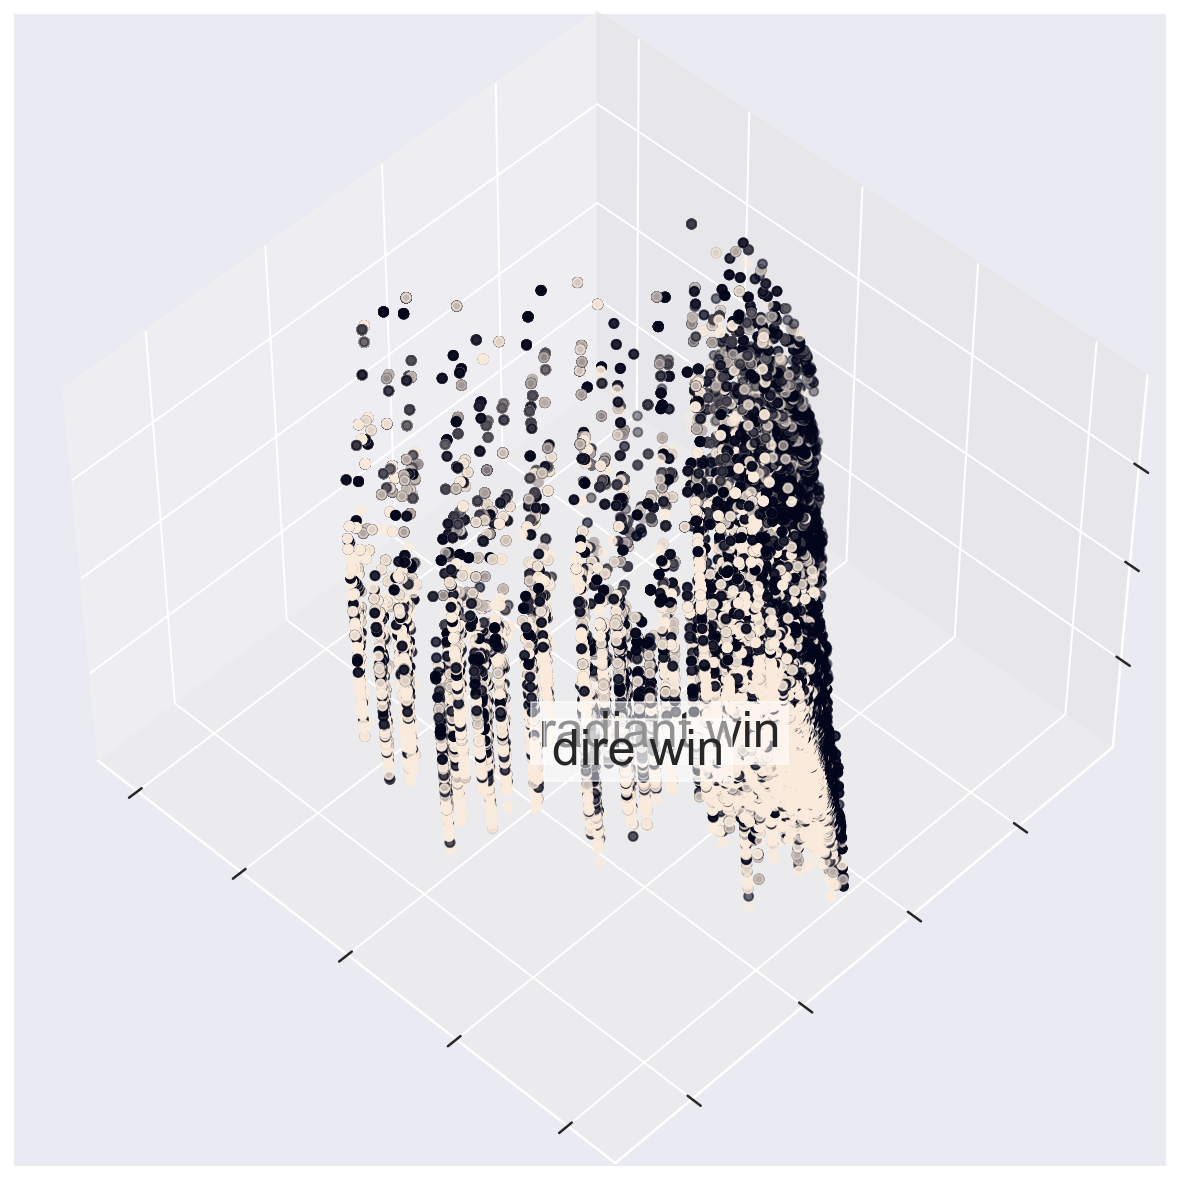

In [33]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, elev=48, azim=134)

for t in {0, 1}:
  ax.text3D(X_train_pca_3.values[y_train == t, 0].mean(),
            X_train_pca_3.values[y_train == t, 1].mean() + 1.5,
            X_train_pca_3.values[y_train == t, 2].mean(), label[t], horizontalalignment='center',
            bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

ax.scatter(X_train_pca_3.values[:, 0],
           X_train_pca_3.values[:, 1],
           X_train_pca_3.values[:, 2], c=y_train) #plotting the 3 clusters

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()